
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Main Figure 5
-----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import seaborn as sns

from importlib import reload

import os
import sys
import random

A_col = "#3288BD"
B_col = "#D53E4F"

import warnings
warnings.filterwarnings('ignore')

random.seed(42)

-----
##### Set up input / output directories

In [2]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [3]:
sys.path.append(str(root_dir))
import scripts.ml_utils as mu

-----
##### Load & prepare data 

In [4]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.tsv'), sep='\t', index_col=0)

kzm611_nhm = kzm611_md[kzm611_md.Burden=='low'].copy()
nhm_samples = kzm611_nhm.index.tolist()

naive_samples = kzm611_md[kzm611_md.Therapy=='Pre-Therapy'].index.tolist()
treated_samples = kzm611_md[kzm611_md.Therapy=='Post-Therapy'].index.tolist()

naive_nhm_samples = [x for x in naive_samples if x in nhm_samples]
treated_nhm_samples = [x for x in treated_samples if x in nhm_samples]

In [9]:
## Load df for samples that passed both time & burden thresholds to show platinum signature
topr_quad = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_topRightQuad.tsv'), sep='\t', index_col=0)
topr_quad_samples = topr_quad.index.tolist()
print(f"Number of samples above time & burden thresholds: {len(topr_quad_samples)}")

## Divie samples into sig- & sig+ groups
sigN_sbs_samples = topr_quad[topr_quad.Platin_sbs=='N'].index.tolist()
sigP_sbs_samples = topr_quad[topr_quad.Platin_sbs=='Y'].index.tolist()
sigN_dbs_samples = topr_quad[topr_quad.Platin_dbs=='N'].index.tolist()
sigP_dbs_samples = topr_quad[topr_quad.Platin_dbs=='Y'].index.tolist()

Number of samples above time & burden thresholds: 111


In [6]:
len(list(set(sigN_sbs_samples+sigN_dbs_samples))), len(list(set(sigP_sbs_samples+sigP_dbs_samples)))

(55, 78)

In [7]:
topr_quad.Platin_sbs.value_counts(), topr_quad.Platin_dbs.value_counts()

(Platin_sbs
 Y    66
 N    45
 Name: count, dtype: int64,
 Platin_dbs
 Y    68
 N    43
 Name: count, dtype: int64)

In [32]:
## Load mutation catalogs for various SBS mutation type configurations
fn96 = os.path.join(root_dir, 'source_data/KZM_mutation_catalogs/KZM.SBS96.all')
fn78 = os.path.join(root_dir, 'source_data/KZM_mutation_catalogs/KZM.DBS78.all')
fn288 = os.path.join(root_dir, 'source_data/KZM_mutation_catalogs/KZM.SBS288.all')

mat96_df, mat96_rel, mat96_nhm, mat96_nhm_rel = mu.get_context(fn96, nhm_samples)
mat78_df, mat78_rel, mat78_nhm, mat78_nhm_rel = mu.get_context(fn78, nhm_samples)
mat288_df, mat288_rel, mat288_nhm, mat288_nhm_rel = mu.get_context(fn288, nhm_samples)

In [9]:
mat96_rel.head(2)

MutationType,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
I-H-108298-T1-1-D1-1,0.020130,0.018883,0.002405,0.017814,0.012292,0.005077,0.002138,0.010689,0.020397,0.008373,...,0.004721,0.015587,0.017102,0.020932,0.010510,0.019863,0.004632,0.002672,0.008640,0.009174
I-H-108317-T1-1-D1-1,0.019355,0.020584,0.000922,0.015054,0.007373,0.005223,0.001536,0.007066,0.032565,0.013210,...,0.005223,0.021198,0.007066,0.007373,0.005837,0.015975,0.003379,0.003687,0.004301,0.007988


-----------
## Panel a

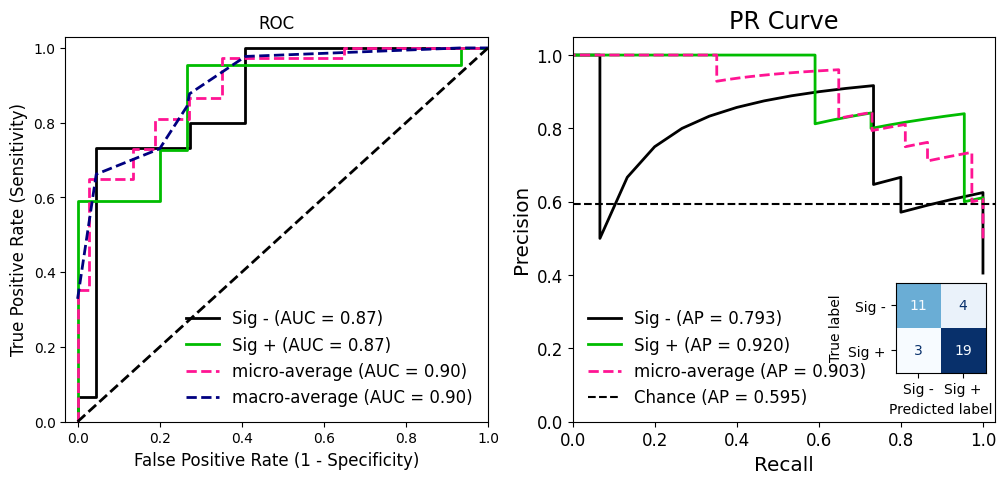

In [74]:
reload(mu)
voting_sbs = mu.get_votingClf_v1(mat96_rel, sigN_sbs_samples, sigP_sbs_samples, cv=True, extra_plots=True)
plt.savefig(os.path.join(fig_out, 'Fig_5a.pdf'), bbox_inches="tight")

-----------
## Panel b

In [75]:
## Load COSMIC SBS signatures
cos_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/COSMIC_Sigs/COSMIC_v3.3.1_SBS_GRCh37.txt'), sep='\t', index_col=0).T
## Subset platinum signatures
cos_sigs.loc['SBS3135'] = cos_sigs.loc[['SBS31', 'SBS35']].mean()

## Load KZM novel signatures
novel_sigs288 = pd.read_csv(os.path.join(root_dir, 'source_data/SBS288_novelSigs.txt'), sep='\t', index_col=0)
## Re-format from 288 to 96
novel_sigs288['mut_type'] = [x.split(":")[-1] for x in novel_sigs288.index]
novel_sigs96 = novel_sigs288.groupby('mut_type').sum().T

## Combine COSMIC & novel platinum signatures
plat_sigs = pd.concat([novel_sigs96, cos_sigs.loc[['SBS31', 'SBS35']]], axis=0)
plat_sigs = plat_sigs.loc[['SBS31', 'SBS35', 'SBS288L5']]
plat_sigs

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS31,0.009535,0.018490,0.001659,0.006277,0.008316,0.003158,0.002998,0.003778,0.017691,0.009275,...,0.003268,0.008875,0.004588,0.010295,0.004008,0.012094,0.002249,0.002379,0.005347,0.007296
SBS35,0.008827,0.046184,0.001390,0.021593,0.003579,0.004548,0.000346,0.009477,0.002209,0.003989,...,0.001380,0.005408,0.000368,0.000822,0.000438,0.001060,0.004289,0.001939,0.004818,0.003619
SBS288L5,0.006269,0.035428,0.000699,0.014305,0.004061,0.002184,0.000536,0.004809,0.007809,0.003252,...,0.004904,0.006271,0.005526,0.008112,0.002891,0.005834,0.001956,0.003093,0.006907,0.003230


In [76]:
## Identify peaks > 5%
sbs31_peaks_05 = plat_sigs.loc['SBS31'][plat_sigs.loc['SBS31'].ge(0.05)].index.tolist()
sbs35_peaks_05 = plat_sigs.loc['SBS35'][plat_sigs.loc['SBS35'].ge(0.05)].index.tolist()
sbs288L5_peaks_05 = plat_sigs.loc['SBS288L5'][plat_sigs.loc['SBS288L5'].ge(0.05)].index.tolist()
cosm_peaks_05 = list(set(sbs31_peaks_05 + sbs35_peaks_05))
plat_peaks_05 = list(set(cosm_peaks_05 + sbs288L5_peaks_05))

## Identify peaks > 2%
sbs31_peaks_02 = plat_sigs.loc['SBS31'][plat_sigs.loc['SBS31'].ge(0.02)].index.tolist()
sbs35_peaks_02 = plat_sigs.loc['SBS35'][plat_sigs.loc['SBS35'].ge(0.02)].index.tolist()
sbs288L5_peaks_02 = plat_sigs.loc['SBS288L5'][plat_sigs.loc['SBS288L5'].ge(0.02)].index.tolist()
cosm_peaks_02 = list(set(sbs31_peaks_02 + sbs35_peaks_02))
plat_peaks_02 = list(set(cosm_peaks_02 + sbs288L5_peaks_02))

sbs31_peaks_05

['C[C>T]C', 'C[C>T]T']

In [10]:
def get_report(mat, naives, treats, model='voting', cat='G0'):
    if model=='voting':
        report, vc_scores = mu.get_votingClf_v1(mat, naives, treats, cv=True, extra_plots=False)
    else:
        return 'Please provide a valid model: voting'
    
    report = report.loc[['Sig -', 'Sig +']]
    report = report.reset_index().rename(columns={'index':'Signature'})
    report['Category'] = cat

    vc_scores.insert(0, 'Category', cat)
    return report, vc_scores


report1_lr, vc_scores_1 = get_report(mat96_rel, sigN_sbs_samples, sigP_sbs_samples, model='voting', cat='All')
report05_lr, vc_scores_05 = get_report(mat96_rel.drop(plat_peaks_05, axis=1), sigN_sbs_samples, sigP_sbs_samples, model='voting', cat=">5%")
report02_lr, vc_scores_02 = get_report(mat96_rel.drop(plat_peaks_02, axis=1), sigN_sbs_samples, sigP_sbs_samples, model='voting', cat=">2%")

'''report1_rf = get_report(mat96_rel, sigN_samples, sigP_samples, model='rf', cat='All')
report05_rf = get_report(mat96_rel.drop(plat_peaks_05, axis=1), sigN_samples, sigP_samples, model='rf', cat=">5%")
report02_rf = get_report(mat96_rel.drop(plat_peaks_02, axis=1), sigN_samples, sigP_samples, model='rf', cat=">2%")'''



reports_lr = pd.concat([report1_lr, report05_lr, report02_lr], axis=0).reset_index(drop=True)
#reports_rf = pd.concat([report1_rf, report05_rf, report02_rf], axis=0).reset_index(drop=True)

reports_sigN_lr = reports_lr[reports_lr.Signature=='Sig -']
reports_sigP_lr = reports_lr[reports_lr.Signature=='Sig +']

#reports_sigN_rf = reports_rf[reports_rf.Signature=='Sig -']
#reports_sigP_rf = reports_rf[reports_rf.Signature=='Sig +']
vc_scores = pd.concat([vc_scores_1, vc_scores_05, vc_scores_02], axis=0).set_index('Category')

reports_lr, vc_scores

(  Signature  precision    recall  f1-score  support Category
 0     Sig -   0.785714  0.733333  0.758621     15.0      All
 1     Sig +   0.826087  0.863636  0.844444     22.0      All
 2     Sig -   0.571429  0.533333  0.551724     15.0      >5%
 3     Sig +   0.695652  0.727273  0.711111     22.0      >5%
 4     Sig -   0.538462  0.466667  0.500000     15.0      >2%
 5     Sig +   0.666667  0.727273  0.695652     22.0      >2%,
           Avg_CV_Recall  SD_CV_Recall  Avg_CV_Precision  SD_CV_Precision  \
 Category                                                                   
 All            0.883333      0.162447          0.910000         0.102470   
 >5%            0.797222      0.142860          0.876010         0.125020   
 >2%            0.841667      0.058597          0.838232         0.124003   
 
           Avg_CV_f1-score  SD_CV_f1-score  
 Category                                   
 All              0.888947        0.107676  
 >5%              0.821648        0.088110 

In [11]:
vc_scores_vals = vc_scores[[x for x in vc_scores.columns if x.startswith('Avg')]].copy()
vc_scores_yerr = vc_scores[[x for x in vc_scores.columns if x.startswith('SD')]].copy()
vc_scores_vals.columns = ['Recall', 'Precision', 'F1-score']
vc_scores_yerr.columns = ['Recall', 'Precision', 'F1-score']

In [35]:
vc_scores_vals = vc_scores_vals[['Recall', 'F1-score', 'Precision']]
vc_scores_yerr = vc_scores_yerr[['Recall', 'F1-score', 'Precision']]

In [ ]:
mute_cols = sns.color_palette("muted")   #['#86BBD8', '#878E99', '#33658B']

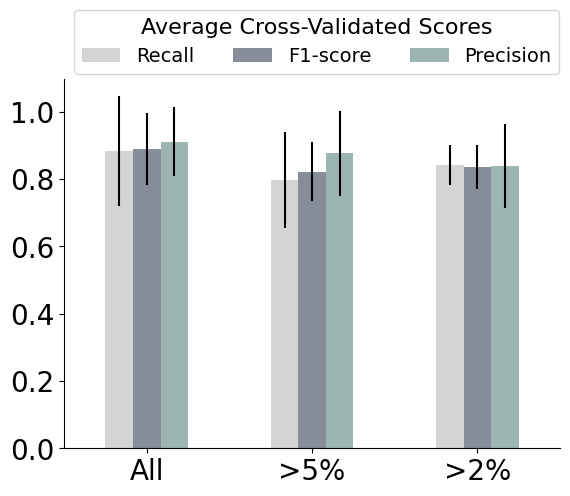

In [62]:
fig2,ax2 = plt.subplots()
vc_scores_vals.plot(kind='bar',yerr=vc_scores_yerr, color=['#D3D5D4', '#878E99', '#9DB5B2'], ax=ax2)
leg =ax2.legend(loc='center left', bbox_to_anchor=(0, 1.1), ncols=3, title='Average Cross-Validated Scores', fontsize=14)
leg.get_title().set_fontsize('16')
ax2.spines[['top', 'right']].set_visible(False)
ax2.set_xlabel('')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=20)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)

plt.savefig(os.path.join(fig_out, 'Fig_5b.pdf'), bbox_inches="tight")

-----------
## Panels c-d

In [10]:
## Load therapy data at class and individual drug levels
class_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_classes_NY.txt'), sep='\t', index_col=0)
drugs_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_individuals_counts.txt'), sep='\t', index_col=0)

drugs_df = drugs_df.apply(lambda x: ['Y' if y > 0 else 'N' for y in x])
drugs_df = drugs_df.drop([x for x in drugs_df.columns if 'Y' not in drugs_df[x].tolist()], axis=1)

In [11]:
## Get treatment-naive samples above the burden threshold
burden_thresh = 1453
nhm_naives_thresh = [x for x in naive_nhm_samples if kzm611_nhm.loc[x, 'SBS'] >= burden_thresh]
print(f"Number of treatment-naive samples above burden threshold: {len(nhm_naives_thresh)}")

Number of treatment-naive samples above burden threshold: 157


In [7]:
pret_samples = kzm611_md[kzm611_md.Therapy=='Pre-Therapy'].index.tolist()

In [12]:
reps = 100
platPos_samples = class_df[class_df.Platinums=='Y'].index.tolist()

In [62]:
def get_report_boot(mat, naives, treats, cat='G0'):
    #report = mu.get_logreg_topq_v2(mat, naives, treats, cv=True, extra_plots=False)
    report = mu.get_votingClf_v1(mat, naives, treats, cv=True, extra_plots=False)
    
    report = report.loc[['Sig -', 'Sig +']]
    report = report.reset_index().rename(columns={'index':'Signature'})
    report['Category'] = cat
    return report


def report_boot(mat, reps):
    reports = pd.DataFrame()

    for i in range(reps):
        print('###\n{rep} iteration ...\n')
        pret_random1 = random.sample(pret_samples, k=len(platPos_samples))
        pret_random2 = random.sample(pret_samples, k=len(topr_quad_samples))
        pret_random3 = random.sample(pret_samples, k=len(sigP_sbs_samples))
        pret_random4 = random.sample(pret_samples, k=len(sigN_sbs_samples))

        reports = pd.concat([reports, get_report_boot(mat, pret_random1, platPos_samples, cat='Platinum\nTreated')], axis=0).reset_index(drop=True)
        reports = pd.concat([reports, get_report_boot(mat, pret_random2, topr_quad_samples, cat="TopRQ")], axis=0).reset_index(drop=True)
        reports = pd.concat([reports, get_report_boot(mat, pret_random3, sigP_sbs_samples, cat="Sig+")], axis=0).reset_index(drop=True)
        reports = pd.concat([reports, get_report_boot(mat, pret_random4, sigN_sbs_samples, cat="Sig-")], axis=0).reset_index(drop=True)
    reports.columns = ['Signature', 'Precision', 'Recall', 'F1-score', 'Support', 'Positive Class (in Red)']
    return reports


In [16]:
len(topr_quad_samples), len(platPos_samples)

(111, 172)

In [26]:
reload(mu)

<module 'helper_functions.ml_utils' from '/Users/mehdi/Documents/MyRepos/MS1_codes/helper_functions/ml_utils.py'>

In [63]:
reports96_1h = report_boot(mat96_rel, reps=100)
#reports288_1h = report_boot(mat288_rel, reps=100)

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...

###
{rep} iteration ...



In [ ]:
#reports96_1h.to_csv(os.path.join(root_dir, 'source_data/reports96_1h_v2.tsv'), sep='\t')

In [80]:
#reports96_1h.to_csv(os.path.join(root_dir, 'source_data/reports96_1h.tsv'), sep='\t')
reports96_1h = pd.read_csv(os.path.join(root_dir, 'source_data/reports96_1h_v2.tsv'), sep='\t', index_col=0)


In [81]:
reports96_1h.head(2)

,Signature,Precision,Recall,F1-score,Support,Positive Class (in Red)
0,Sig -,0.784615,0.894737,0.836066,57.0,Platinum\nTreated
1,Sig +,0.877551,0.754386,0.811321,57.0,Platinum\nTreated


In [13]:
pret_random_topq = random.sample(pret_samples, k=len(topr_quad_samples))
pret_random_P = random.sample(pret_samples, k=len(sigP_sbs_samples))
pret_random_N = random.sample(pret_samples, k=len(sigN_sbs_samples))

In [ ]:
model_ind, features_N = mu.shap_swarm_single(mat96_rel, pret_random_N, sigN_sbs_samples)
model_ind, features_P = mu.shap_swarm_single(mat96_rel, pret_random_P, sigP_sbs_samples)

features_df_N = mu.feats_2df(features_N, 'Sig-')
features_df_P = mu.feats_2df(features_P, 'Sig+')

In [33]:
model_ind, features_S = mu.shap_swarm_single(mat96_rel, sigN_sbs_samples, sigP_sbs_samples)
features_df_S = mu.feats_2df(features_S, 'Sig-/+')

In [85]:
features_df_Q = pd.DataFrame()
for i in range(100):
    pret_random2 = random.sample(pret_samples, k=len(topr_quad_samples))
    model_ind, features_Q = mu.shap_swarm_single(mat96_rel, pret_random2, topr_quad_samples)
    features_df_Q = pd.concat([features_df_Q, mu.feats_2df(features_Q, 'TopRQ')], axis=1)
features_df_Q['total'] = features_df_Q.mean(axis=1)
features_df_Q.head(2)

,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,...,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,TopRQ,total
A[C>A]A,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000196
A[C>A]C,0.0,0.005148,0.0,0.0,0.0,0.0,0.006462,0.0,0.00733,0.0,...,0.0,0.0,0.0,0.0,0.0,0.012318,0.0,0.007556,0.0,0.004994


In [86]:
colors = {'C>A': [3 / 256, 189 / 256, 239 / 256],
          'C>G': [1 / 256, 1 / 256, 1 / 256],
          'C>T': [228 / 256, 41 / 256, 38 / 256],
          'T>A': [203 / 256, 202 / 256, 202 / 256],
          'T>C': [162 / 256, 207 / 256, 99 / 256],
          'T>G': [236 / 256, 199 / 256, 197 / 256],
}

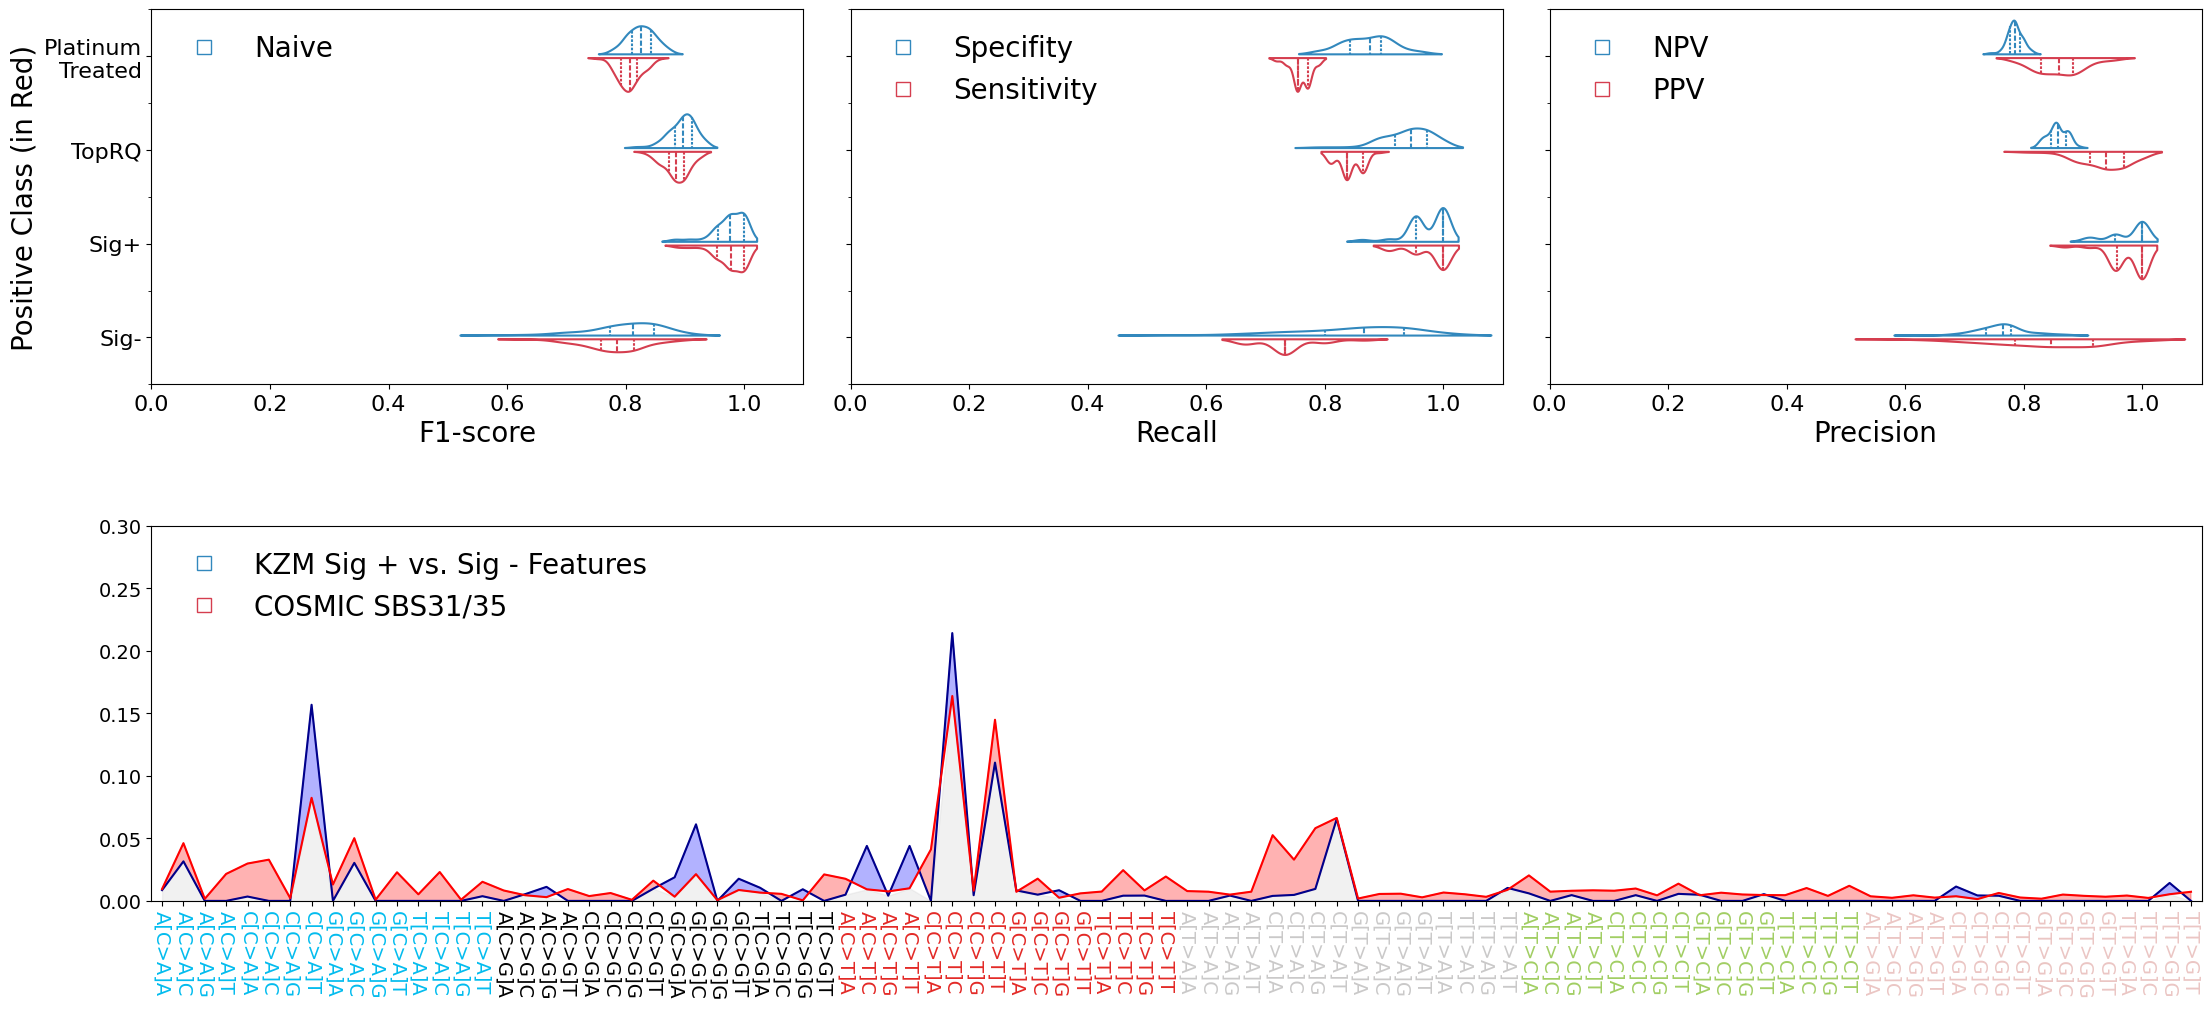

In [87]:
fig3 = plt.figure(figsize=(22,10), constrained_layout=True)
gs = fig3.add_gridspec(13, 3)
f3_ax1 = fig3.add_subplot(gs[0:6, 0])

vp = sns.violinplot(data=reports96_1h, y="Positive Class (in Red)", x="F1-score", hue="Signature",
                    split=True, gap=.1, inner="quart", palette={'Sig -': A_col, 'Sig +': B_col},
                    fill=False, ax=f3_ax1)
custom_lines = [Line2D([], [], color=A_col, marker='s', markerfacecolor='none', markersize=10, linestyle='none', lw=4)]
f3_ax1.legend(custom_lines, ['Naive'], loc='upper left', fontsize=20, frameon=False)
f3_ax1.set_xlim(0, 1.1)
f3_ax1.xaxis.get_label().set_fontsize(20)
f3_ax1.yaxis.get_label().set_fontsize(20)
f3_ax1.tick_params(axis='both', which='major', labelsize=16)


f3_ax2 = fig3.add_subplot(gs[0:6, -2], sharey=f3_ax1)
plt.setp(f3_ax2.get_yticklabels(), visible=False)

vp = sns.violinplot(data=reports96_1h, y="Positive Class (in Red)", x="Recall", hue="Signature",
                    split=True, gap=.1, inner="quart", palette={'Sig -': A_col, 'Sig +': B_col},
                    fill=False, ax=f3_ax2)

custom_lines2 = [Line2D([], [], color=A_col, marker='s', markerfacecolor='none', markersize=10, linestyle='none', lw=4),
                 Line2D([], [], color=B_col, marker='s', markerfacecolor='none', markersize=10, linestyle='none', lw=4)]
f3_ax2.legend(custom_lines2, ['Specifity', 'Sensitivity'], loc='upper left', fontsize=20, frameon=False)
f3_ax2.set_xlim(0, 1.1)
f3_ax2.xaxis.get_label().set_fontsize(20)
f3_ax2.yaxis.get_label().set_fontsize(20)
f3_ax2.tick_params(axis='both', which='major', labelsize=16)


f3_ax3 = fig3.add_subplot(gs[0:6, -1], sharey=f3_ax1)
plt.setp(f3_ax3.get_yticklabels(), visible=False)

vp = sns.violinplot(data=reports96_1h, y="Positive Class (in Red)", x="Precision", hue="Signature",
                    split=True, gap=.1, inner="quart", palette={'Sig -': A_col, 'Sig +': B_col},
                    fill=False, ax=f3_ax3)

custom_lines3 = [Line2D([], [], color=A_col, marker='s', markerfacecolor='none', markersize=10, linestyle='none', lw=4),
                 Line2D([], [], color=B_col, marker='s', markerfacecolor='none', markersize=10, linestyle='none', lw=4)]
f3_ax3.legend(custom_lines3, ['NPV', 'PPV'], loc='upper left', fontsize=20, frameon=False)
f3_ax3.set_xlim(0, 1.1)
f3_ax3.xaxis.get_label().set_fontsize(20)
f3_ax3.yaxis.get_label().set_fontsize(20)
f3_ax3.tick_params(axis='both', which='major', labelsize=16)


f3_ax4 = fig3.add_subplot(gs[7:, :])

feats96_df1_extra = pd.concat([features_df_S, cos_sigs.loc[['SBS31', 'SBS35']].T], axis=1)
feats96_df1_extra['SBS31/35'] = feats96_df1_extra[['SBS31', 'SBS35']].max(axis=1)
feats96_df1_extra[['Sig-/+', 'SBS31/35']].plot(color=['darkblue', 'red'], ax=f3_ax4)
f3_ax4.set_xticks(list(range(0, len(feats96_df1_extra))), feats96_df1_extra.index)
plt.setp(f3_ax4.xaxis.get_majorticklabels(), rotation=-90, ha="center", fontsize=8)
plt.fill_between(feats96_df1_extra.index, feats96_df1_extra[['Sig-/+', 'SBS31/35']].min(axis=1), color='lightgray', alpha=0.3)
plt.fill_between(feats96_df1_extra.index, feats96_df1_extra['Sig-/+'], feats96_df1_extra['SBS31/35'],
                 where=(feats96_df1_extra['Sig-/+'] > feats96_df1_extra['SBS31/35']), color='blue', alpha=0.3, interpolate=True)
plt.fill_between(feats96_df1_extra.index, feats96_df1_extra['Sig-/+'], feats96_df1_extra['SBS31/35'],
                 where=(feats96_df1_extra['Sig-/+'] < feats96_df1_extra['SBS31/35']), color='red', alpha=0.3, interpolate=True)
f3_ax4.set_xlim(-0.5, 95.5)
f3_ax4.set_ylim(0, 0.3)
f3_ax4.tick_params(axis='both', which='major', labelsize=14)

f3_ax4.legend(custom_lines3, ['KZM Sig + vs. Sig - Features', 'COSMIC SBS31/35'], loc='upper left', fontsize=20, frameon=False)

labels = f3_ax4.get_xticklabels()
for label in labels:
    label.set_color(colors[label.get_text()[2:5]])

plt.savefig(os.path.join(fig_out, 'Fig_5cd.pdf'), bbox_inches="tight", dpi=300)